In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
FOLDERNAME = 'Colab Notebooks/RLHF_final'
%cd /content/drive/My\ Drive/$FOLDERNAME/
!ls

/content/drive/My Drive/Colab Notebooks/RLHF_final
data  extract_features.py  load_data.py  __pycache__


In [ ]:
!python extract_features.py

Traceback (most recent call last):
  File "/content/drive/My Drive/Colab Notebooks/RLHF_final/extract_features.py", line 79, in <module>
    main()
  File "/content/drive/My Drive/Colab Notebooks/RLHF_final/extract_features.py", line 63, in main
    raise Exception("Features already extracted")
Exception: Features already extracted


In [ ]:
%cd /content/drive/My\ Drive/$FOLDERNAME/
from load_data import load_json_data

# Load data
data = load_json_data("data/result.json", 1000, 1519)
data[-1]

/content/drive/My Drive/Colab Notebooks/RLHF_final


[{'filename': '03573_0',
  'sentence1': 'A building has been constructed on the empty area at the edge of the scene ',
  'sentence2': 'The roof of the buildings at the edge of the scene has turned from blue to gray ',
  'sentence3': 'the roof of the buildings at the edge of the scene has turned from blue to gray ',
  'slider1': -5,
  'slider2': -2,
  'slider3': -2},
 {'filename': '03573_1',
  'sentence1': 'A building has been constructed on the green area at the edge of the scene ',
  'sentence2': 'The blue building at the edge of the scene has turned blue ',
  'sentence3': 'The green area at the edge of the scene has turned blue ',
  'slider1': 4,
  'slider2': -5,
  'slider3': 1},
 {'filename': '03573_2',
  'sentence1': 'many trees appear on the bareland at the corner of the scene ',
  'sentence2': 'the bareland appears on the edge of the scene ',
  'sentence3': 'bareland appears on the buildings at the corner of the scene ',
  'slider1': -5,
  'slider2': -4,
  'slider3': -5},
 {'file

In [ ]:
import numpy as np

features_im1 = np.load(f"data/features/im1.npy")
# features shape is (2084, 2048, 1, 1)
features_im1 = features_im1.reshape((2084, 2048))

features_im2 = np.load(f"data/features/im2.npy")
features_im2 = features_im2.reshape((2084, 2048))

features_im1.shape, features_im2.shape

((2084, 2048), (2084, 2048))

#### Encoding The Sentences With BERT model

In [ ]:
import numpy as np
import torch
import tqdm
from transformers import BertTokenizer, BertModel

def bert_encode(sentences, bert_model, tokenizer, device, batch_size=32):
    bert_model.to(device)
    bert_model.eval()  # Modeli değerlendirme modunda çalıştır

    # Tüm cümleleri batch'ler halinde işle
    all_sentence_embeddings = []
    for i in tqdm.tqdm(range(0, len(sentences), batch_size), desc="BERT Encoding"):
        batch_sentences = sentences[i:i+batch_size]
        encoded = tokenizer.batch_encode_plus(
            batch_sentences,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        with torch.no_grad():
            outputs = bert_model(input_ids, attention_mask=attention_mask)
            sentence_embeddings = outputs[0][:, 0, :]  # [CLS] token'ın çıktısını al
            all_sentence_embeddings.extend(sentence_embeddings.cpu().numpy())

    return np.array(all_sentence_embeddings)

def collect_all_sentences(data):
    all_sentences = []
    sentence_lengths = []
    for data_point in data:
        for data_point_caption in data_point:
            for i in range(1, 4):
                all_sentences.append(data_point_caption["sentence" + str(i)])
    return all_sentences


# Load BERT model
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Collect all sentences
all_sentences = collect_all_sentences(data)

# Encode sentences
sentence_embeddings = bert_encode(all_sentences, bert_model, tokenizer, device, batch_size=128)

#free gpu memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()


sentence_embeddings.shape

BERT Encoding: 100%|██████████| 49/49 [03:37<00:00,  4.44s/it]


(6252, 768)

#### Prepare Training Data

In [ ]:
combined_features = []
combined_labels = []
slider_values = []

for data_point in data:
    for i in range(0, 4):
        for j in range(1, 4):
            slider_values.append(data_point[i]["slider" + str(j)])

slider_values = np.array(slider_values)


import numpy as np
from sklearn.model_selection import train_test_split

# Assuming the following shapes
# before_feature.shape = (2084, 2048)
# after_feature.shape = (2084, 2048)
# bert_encoded_sentences.shape = (6252, 768)
# slider_values.shape = (6252,)

# The number of sentences per image pair
sentences_per_image_pair = sentence_embeddings.shape[0] // features_im1.shape[0]

# Combining features
combined_features = []
for i in range(features_im1.shape[0]):
    for j in range(sentences_per_image_pair):
        sentence_index = i * sentences_per_image_pair + j
        combined_feature = np.concatenate([features_im1[i], features_im2[i], sentence_embeddings[sentence_index]])
        combined_features.append(combined_feature)

combined_features = np.array(combined_features)

# Check if the combined features align with the slider values
assert combined_features.shape[0] == slider_values.shape[0]

# Shuffle and split the data
X_train, X_test, y_train, y_test = train_test_split(combined_features, slider_values, test_size=0.2, random_state=42, shuffle=True)

combined_features.shape

(6252, 4864)

#### Scaling The Data

In [ ]:
# Scale the data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_test[0]

array([-0.8220586 , -0.84335107,  1.2922608 , ...,  0.2619933 ,
        0.7300415 ,  0.24618685], dtype=float32)

In [ ]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Check if TensorFlow is able to recognize the GPU
if tf.test.gpu_device_name():
    print(f"Default GPU Device: {tf.test.gpu_device_name()}")
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


#### Train The Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization

model = Sequential()

# Input layer with L2 regularization
model.add(Dense(4864, input_dim=4864, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())

# Hidden layer with L2 regularization
model.add(Dense(1024, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Another hidden layer with L2 regularization
model.add(Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(1, activation=None))

# Compile model with a custom learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mean_squared_error'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Summary
model.summary()

# Fit model
model.fit(
    X_train, y_train,
    epochs=1000,
    batch_size=128,
    validation_split=0.2,  # Use either validation_split or validation_data
    callbacks=[early_stop, model_checkpoint]
)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 4864)              23663360  
                                                                 
 batch_normalization_6 (Bat  (None, 4864)              19456     
 chNormalization)                                                
                                                                 
 dense_34 (Dense)            (None, 1024)              4981760   
                                                                 
 batch_normalization_7 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 1024)              0         
                                                                 
 dense_35 (Dense)            (None, 512)             

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 14s 338ms/step - loss: 93.3752 - mean_squared_error: 16.9383 - val_loss: 98.2176 - val_mean_squared_error: 20.0836
Epoch 2/1000
32/32 [==============================] - 6s 179ms/step - loss: 87.4321 - mean_squared_error: 11.1938 - val_loss: 90.3492 - val_mean_squared_error: 17.1282
Epoch 3/1000
32/32 [==============================] - 5s 173ms/step - loss: 78.3775 - mean_squared_error: 8.4791 - val_loss: 83.3279 - val_mean_squared_error: 17.3171
Epoch 4/1000
32/32 [==============================] - 5s 148ms/step - loss: 69.6917 - mean_squared_error: 7.1659 - val_loss: 71.6184 - val_mean_squared_error: 13.0250
Epoch 5/1000
32/32 [==============================] - 6s 187ms/step - loss: 61.5486 - mean_squared_error: 6.3117 - val_loss: 63.8257 - val_mean_squared_error: 12.3597
Epoch 6/1000
32/32 [==============================] - 5s 145ms/step - loss: 53.5873 - mean_squared_error: 5.3718 - val_loss: 56.5261 - val_mean_squared_error: 11.8365
Epoch 7/

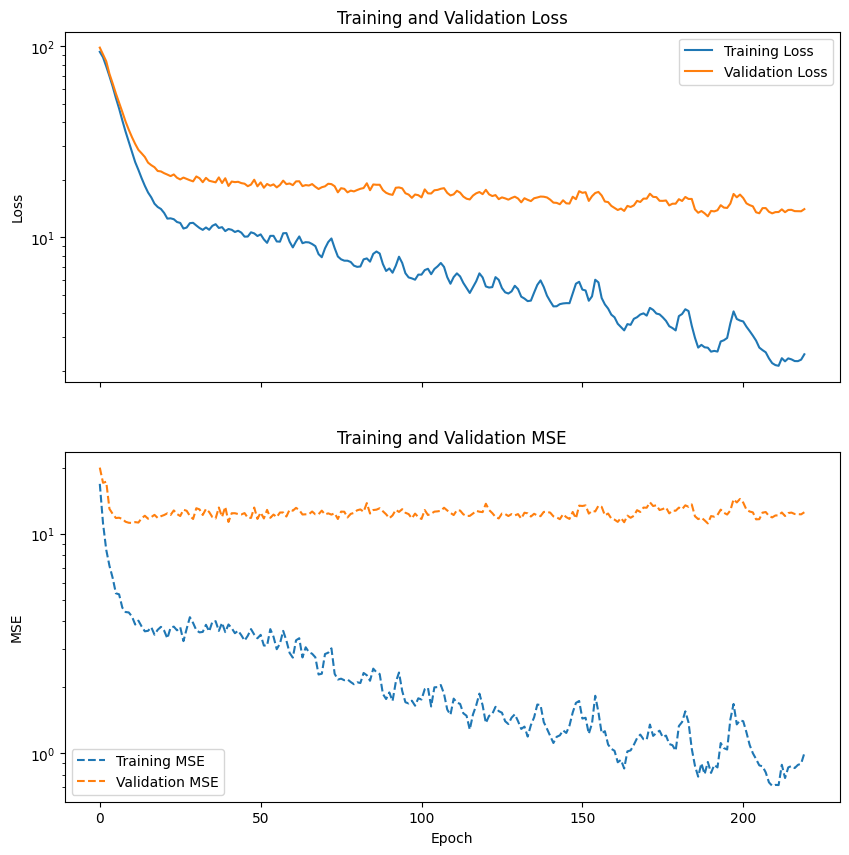

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert model history into a Pandas DataFrame
losses_df = pd.DataFrame(model.history.history)

# Plot the losses and MSE on separate subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# Loss plot
axes[0].plot(losses_df['loss'], label='Training Loss')
axes[0].plot(losses_df['val_loss'], label='Validation Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_yscale('log')

# MSE plot
axes[1].plot(losses_df['mean_squared_error'], label='Training MSE', linestyle='--')
axes[1].plot(losses_df['val_mean_squared_error'], label='Validation MSE', linestyle='--')
axes[1].set_title('Training and Validation MSE')
axes[1].set_ylabel('MSE')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].set_yscale('log')

# Show the plot
plt.show()


40/40 [==============================] - 0s 3ms/step
Mean Squared Error: 13.616109578786856
Mean Absolute Error: 2.6808993579338876


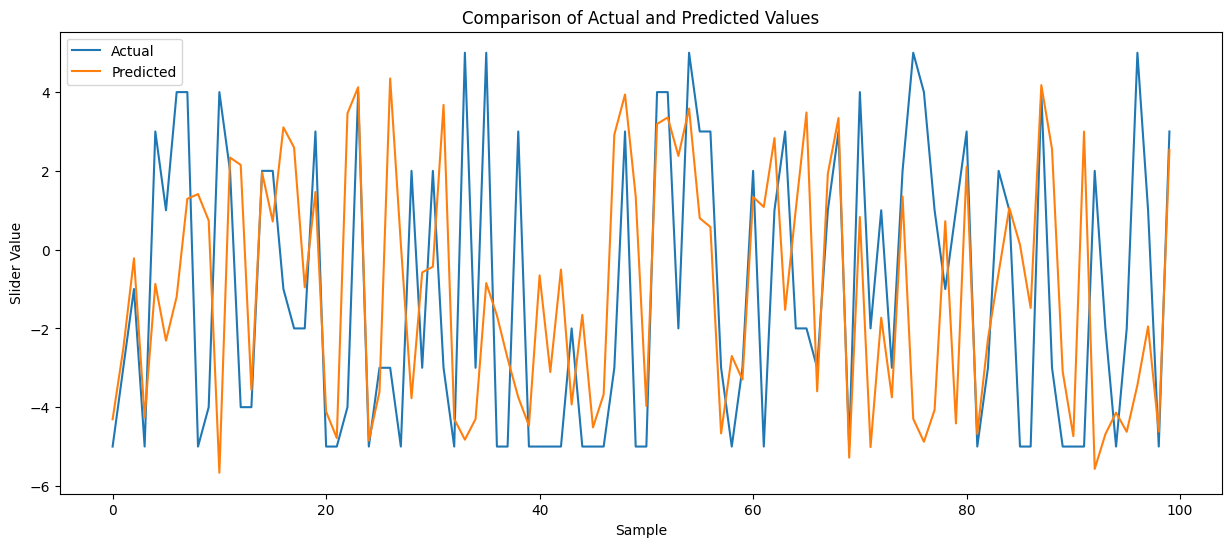

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate MSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

# Plotting the first N test samples for comparison
N = 100  # Number of samples to visualize
plt.figure(figsize=(15, 6))
plt.plot(y_test[:N], label='Actual')
plt.plot(y_pred[:N], label='Predicted')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Slider Value')
plt.legend()
plt.show()